In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Đọc dữ liệu FPT

In [2]:
fpt = pd.read_csv('FPT.csv')

In [3]:
fpt

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [4]:
fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


* Dữ liệu có tất cả 97406 dòng, không dòng nào rỗng 
* Cột Date/Time có kiểu dữ liệu object => sai  kiểu dữ liệu

# Xử lý dữ liệu 

In [5]:
fpt['Date/Time']=pd.to_datetime(fpt['Date/Time'])

In [6]:
fpt['Date']= fpt['Date/Time'].dt.strftime('%Y-%m-%d')

In [7]:
fpt['Date']=pd.to_datetime(fpt['Date'])

In [8]:
fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
 8   Date           97406 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 6.7+ MB


* Cột Date đã sửa đúng kiểu dữ liệu datetime

In [9]:
fpt=fpt[['Date','Close']]

In [10]:
fpt=fpt.groupby(by='Date',sort=False).mean()

In [11]:
fpt.head()

,Close
Date,
2018-12-25,30.760000
2018-12-26,31.050159
2018-12-27,31.331567
2018-12-28,31.321557
2019-01-02,31.232393


* Lấy 2 cột cần thiết là Date và Close

In [12]:
fpt=fpt.pct_change()
fpt.dropna(inplace=True)
fpt=fpt.rename(columns={'Close':'Change'})
fpt.head()

,Change
Date,
2018-12-26,0.009433
2018-12-27,0.009063
2018-12-28,-0.000319
2019-01-02,-0.002847
2019-01-03,-0.020933


* Tính biến động giá cổ phiếu = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.
* Sử dụng hàm pct_change để tính % biến động

# Trực quan hóa dữ liệu

<AxesSubplot:xlabel='Date'>

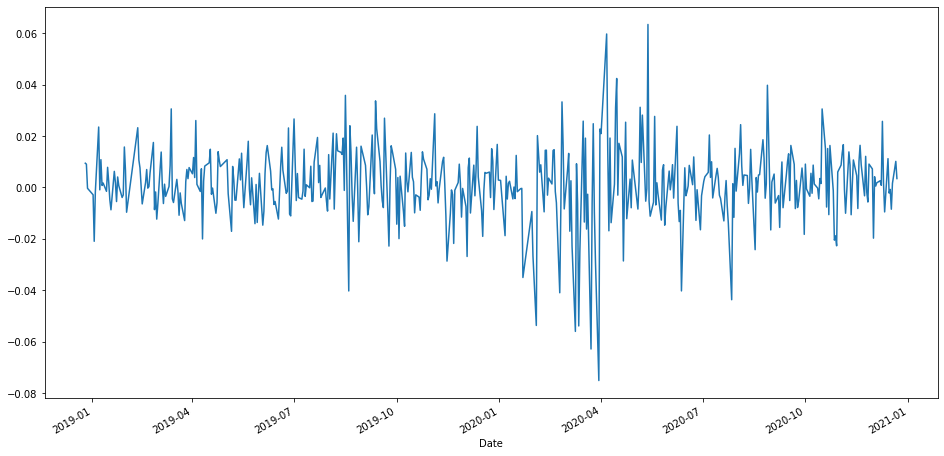

In [13]:
plt.figure(figsize=(16, 8))
fpt['Change'].plot()

(array([  2.,   3.,   5.,  17.,  93., 235., 112.,  25.,   4.,   2.]),
 array([-0.07506649, -0.06122129, -0.04737609, -0.03353089, -0.01968569,
        -0.0058405 ,  0.0080047 ,  0.0218499 ,  0.0356951 ,  0.0495403 ,
         0.0633855 ]),
 <BarContainer object of 10 artists>)

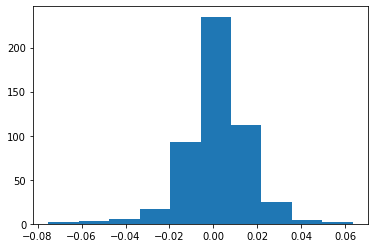

In [14]:
plt.hist(fpt['Change'])

# Xây dựng mô hình dự đoán biến động giá cổ phiếu FPT bằng LSTM

In [15]:
scaler = StandardScaler()
data   = scaler.fit_transform(fpt)

In [16]:
test_len  = round(data.shape[0]*0.2)
train_len = data.shape[0] - test_len
timesteps = 120
features  = 1

X_train = []
y_train = []

for i in range(timesteps, train_len):
    X_train.append(data[i-timesteps:i, :])
    y_train.append(data[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(278, 120, 1) (278, 1)


In [17]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, features)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [18]:
return_sequences=True

In [19]:
X_test = []
y_test = []

for i in range(train_len, data.shape[0]):
    X_test.append(data[i-timesteps:i, :])
    y_test.append(data[i, :])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [20]:
model.fit(X_train, y_train, batch_size=10 ,epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
28/28 [==============================] - 5s 94ms/step - loss: 1.4096 - val_loss: 0.5938
Epoch 2/50
28/28 [==============================] - 2s 72ms/step - loss: 1.4168 - val_loss: 0.6079
Epoch 3/50
28/28 [==============================] - 2s 73ms/step - loss: 1.3954 - val_loss: 0.6046
Epoch 4/50
28/28 [==============================] - 2s 76ms/step - loss: 1.3929 - val_loss: 0.6015
Epoch 5/50
28/28 [==============================] - 2s 84ms/step - loss: 1.3846 - val_loss: 0.6038
Epoch 6/50
28/28 [==============================] - 3s 98ms/step - loss: 1.3869 - val_loss: 0.6108
Epoch 7/50
28/28 [==============================] - 3s 110ms/step - loss: 1.3851 - val_loss: 0.6027
Epoch 8/50
28/28 [==============================] - 2s 85ms/step - loss: 1.3830 - val_loss: 0.6078
Epoch 9/50
28/28 [==============================] - 2s 83ms/step - loss: 1.3881 - val_loss: 0.6043
Epoch 10/50
28/28 [==============================] - 2s 77ms/step - loss: 1.3845 - val_loss: 0.6096
Epoch 11

In [21]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [22]:
rmse = np.sqrt(((y_test - y_pred)**2).mean())
rmse

0.011071640108014449

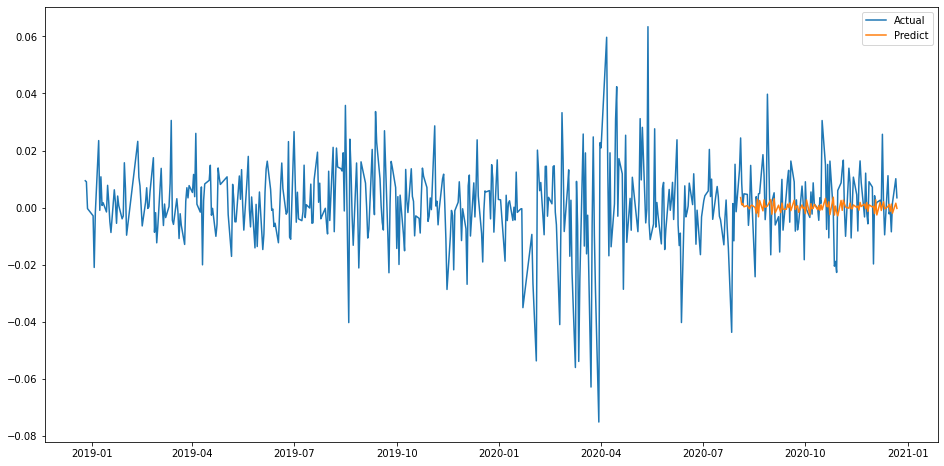

In [23]:
actual = fpt[['Change']]
pred   = fpt[['Change']].iloc[train_len:, :]
pred['Predict'] = y_pred
plt.figure(figsize=(16, 8))
plt.plot(actual, label='Actual')
plt.plot(pred[['Predict']], label='Predict')
plt.legend()
plt.show()